In [1]:
import numpy as np
import pandas as pd

import sys

# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import warnings
warnings.filterwarnings('ignore')

In [2]:
import itertools
from scipy import stats
from scipy.stats import randint as sp_randint
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve

### Classification - Based on Week 3

Q1. Build a classification model for the default of credit card clients dataset. More info here:
https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

In week 3, you:
- Explored the dataset
- Built a full data pipeline
- Pre-processed data, explored features

Building on your work of week 3:
- Split dataset into 3 sets:
  - 70% -> Training and cross validation
  - 15% -> Model Stacking
  - 15% -> Testing
  

- Tune a decision tree classfier:
  - select a score (http://scikit-learn.org/stable/modules/model_evaluation.html). Explain your choice 
  - tune one parameter a time. Generate a plot for the score vs parameter values. Analyze your results.
    - criterion, max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes=None    
  - tune all parameters at the same time using a randomgrid(http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV). First, run with a coarse grid, then refine in the next iteration. Use the information from the previous step to select parameter values.
  

In [3]:
df = pd.read_excel("./datasets/default_of_credit_card_clients.xls", sheet = 0, skiprows= 1, header = 0)

### Preprocessing

1. Drop the ID column

2. Split the data into train (70%), test model (15%), and test sets (15%) which trying to maintain an equal balance of the target column.

In [4]:
df = df.drop('ID', axis=1)

In [5]:
def stratisfy_and_split(data, column, target, random_state = 123):
    """
    Using sklearn's StratifiedShuffleSplit split the data into 70% train and 15% stacking and 15% test but 
    maintaining an equal balance of the requested column.
    
    Args:
        | data: The data to be split
        | column: The column to stratisfy based on
        | target: The target column
        
    Returns:
        | X_train: Features for the train set
        | y_train: Labels for the train set
        | X_stack: Features for the test set
        | y_stack: Labels for the test set
        | X_test: Features for the test set
        | y_test: Labels for the test set
    """
    
    # First let's devide the data into 70 and 30
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=random_state)
    for train_index, test_index in split.split(data, data[column]):
        strat_train_set = data.loc[train_index]
        full_strat_test_set = data.loc[test_index]
        
    full_strat_test_set = full_strat_test_set.reset_index(drop=True)
        
    # Next lets further divide the test set into half: stack and test
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=random_state)
    for stack_index, test_index in split.split(full_strat_test_set, full_strat_test_set[column]):
        strat_stack_set = full_strat_test_set.loc[stack_index]
        strat_test_set = full_strat_test_set.loc[test_index]

    y_train = strat_train_set[target].values
    X_train = strat_train_set.drop(target, axis=1)
   
   
    y_test = strat_test_set[target].values
    X_test = strat_test_set.drop(target, axis=1)
    
   
    y_stack =  strat_stack_set[target].values
    X_stack =  strat_stack_set.drop(target, axis=1)
    
    print(X_stack.shape)
    
    return X_train, y_train, X_stack, y_stack, X_test, y_test

In [6]:
traget_column = 'default payment next month'
X_train, y_train, X_stack, y_stack, X_test, y_test = stratisfy_and_split(df, traget_column, traget_column)

(4500, 23)


In [7]:
X_train.shape, X_stack.shape, X_test.shape

((21000, 23), (4500, 23), (4500, 23))

In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape
print('Train ratio: {}'.format((y_train == 0).sum()/(y_train == 1).sum()))
print('Stack Test ratio: {}'.format((y_stack == 0).sum()/(y_stack == 1).sum()))
print('Test ratio: {}'.format((y_test == 0).sum()/(y_test == 1).sum()))

Train ratio: 3.5209903121636166
Stack Test ratio: 3.5180722891566263
Test ratio: 3.522613065326633


## 1. a) Decision Tree Training

### Score Metric Selection

We have seen the original data was not very balanced having around 3x more negative examples than positive examples so just using *accuracy* as a performance metric may just lead to classifiers that are good at predicting nagative values.

Since we also have far more negative samples than positive we likely don't want to use *auc*.

We can considering using either *precision* or *recall* but which one depends on the goal of our models.

1. Option 1:
 If we want to be sure to flag everyone who may default and aren't worried about having too many false positives we should aim for a higher *recall*
 
 
2. Option 2:
 If we want to be very sure that the individual flagged will default we should instead use *precision*


3. Option 3:
 If we want to get an even balance of precision and recall we could instead the *F1 Score*, because the data is unbalanced the F1 score should be a better indicator of performance than just the accuracy because it takes into account both precision and recall and we likely won't just get a classifier that predicts everyone won't default.

For the sake of the rest of this notebook we will assume *Option 3* holds true so we will evualate our models based on their **F1 Score** to try and determine as many people who will default without inconveniencing too many people who wouldn't.

In [9]:
def plot_confusion_matrix(model, X_test, y_test, ax = None):
    """
    Plots the confusion matrix for a passed in model and the provided test features and labels.
    
    Args:
        | model: Trained model
        | model_type: Type of model that was trained
        | X_test: Features for the test set
        | y_test: Labels for the test set
    """
    
    if ax is None:
        ax = plt.gca()
    
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    classes = ['Did Not Default', 'Defaulted']
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, vmin=0, vmax=1, ax=ax)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.set_title("Confusion Matrix")

In [10]:
def tune_single_parameter(parameter_name, parameter_values):
    """
    Runs on Cross Validation grid search on a single specified parameter over the provided parameter values
    and reports the the best parameter and best scores.
    
    Returns the grid search.
    """
    param_grid = [{parameter_name: parameter_values }]
    decision_tree = DecisionTreeClassifier(random_state=123)
    
    # Use a grid search with F1 Score as the scoring metric and 3 fold cross validaton
    grid_search = GridSearchCV(decision_tree, 
                               param_grid, cv=3, 
                               scoring="f1",
                               return_train_score=False, 
                               n_jobs =-1)
    grid_search.fit(X_train, y_train)
    
    print("Cross Validaton Grid Search Results for {}".format(parameter_name))
    print("The best parameters: {}".format(grid_search.best_params_))
    print("The best score: {}".format(grid_search.best_score_))
    
    return grid_search

In [11]:
def plot_grid_cv_results(cv_results, parameter_name, ax):
    '''
    Plots the train and test error for all the parameters
    '''
    mean_test_scores = cv_results['mean_test_score']
    
    params = [param[parameter_name] for param in cv_results['params']]
    
    # If all the attributes are stings they should be considered not continuous
    discrete = all(isinstance(item, str) for item in params)
    
    # If the values are discrete plot a scatter plot -- if they are continuous plot a line
    if discrete:
        ax.scatter(params, mean_test_scores)
    else:
        ax.plot(params, mean_test_scores)
    ax.set_title('Test Error')
    ax.set_xlabel(parameter_name)
    ax.set_ylabel('F1 Score')
    ax.set_title("{} Parameter Evaluation".format(parameter_name))

In [12]:
def evaulate_parameter(parameter_name, parameter_values):
    grid_search = tune_single_parameter(parameter_name, parameter_values )
        
    fig, ax = plt.subplots(ncols=2, figsize=(15,5))
    plot_grid_cv_results(grid_search.cv_results_, parameter_name,ax=ax[0])
    plot_confusion_matrix(grid_search.best_estimator_, X_test, y_test,ax=ax[1]) 
    return grid_search

### 1. criterion

Cross Validaton Grid Search Results for criterion
The best parameters: {'criterion': 'entropy'}
The best score: 0.40101238623808777


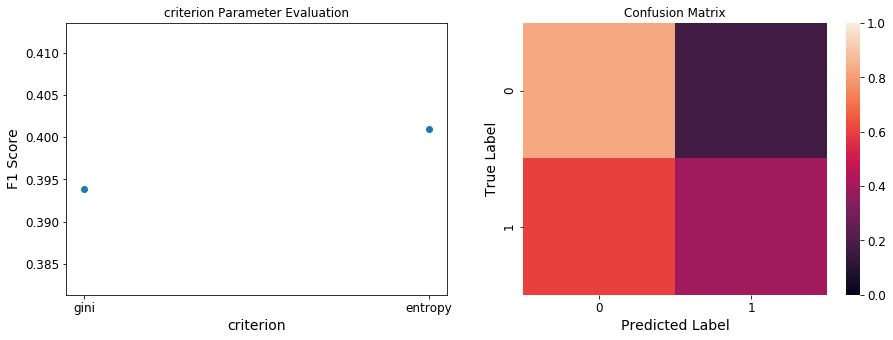

In [13]:
evaulate_parameter('criterion', ['gini', 'entropy']);

### 2. max_depth

Cross Validaton Grid Search Results for max_depth
The best parameters: {'max_depth': 5}
The best score: 0.4642383784094482


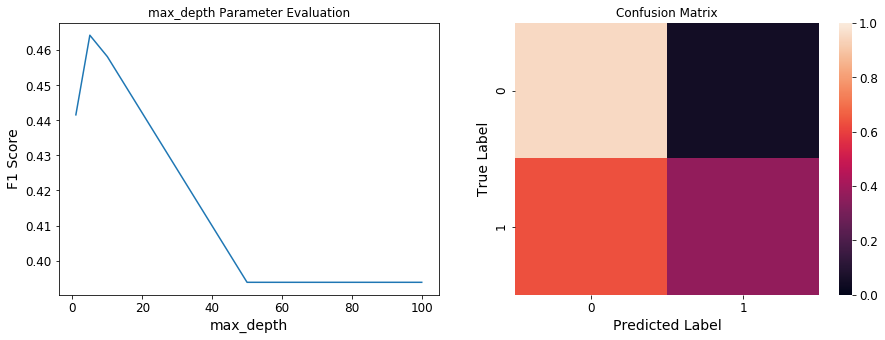

In [14]:
evaulate_parameter('max_depth', [None, 1, 5, 10, 50, 100]);

### 3. min_samples_split

Here we are using a float that represents the fraction of the number of samples instead of a int that is the number of samples.

Cross Validaton Grid Search Results for min_samples_split
The best parameters: {'min_samples_split': 0.07163636363636364}
The best score: 0.4761324074013213


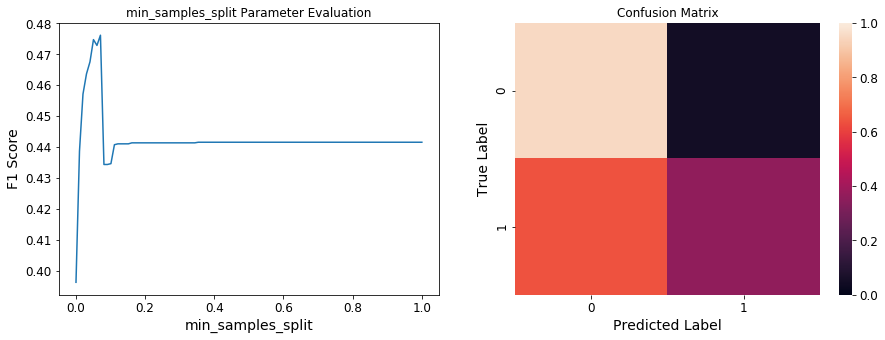

In [15]:
evaulate_parameter('min_samples_split', np.linspace(0.001, 1, 100));

### 3. min_samples_leaf

Again here we use a float to represent the percentage of the samples rather than the number of the samples. For the min samples leaf the percentage can only go to 50% since the splits are 50/50 having a 60% percentage would be the same as having a 40%.

Cross Validaton Grid Search Results for min_samples_leaf
The best parameters: {'min_samples_leaf': 0.016121212121212123}
The best score: 0.48246059502513605


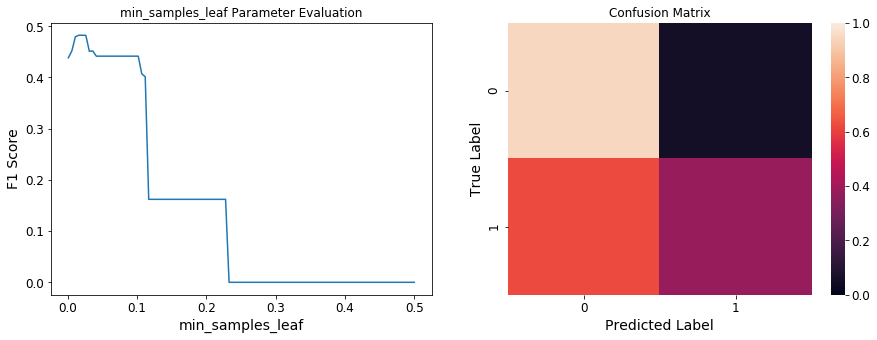

In [16]:
evaulate_parameter('min_samples_leaf', np.linspace(0.001, 0.5, 100));

### 4. max_leaf_nodes

Cross Validaton Grid Search Results for max_leaf_nodes
The best parameters: {'max_leaf_nodes': 10}
The best score: 0.47730422757798224


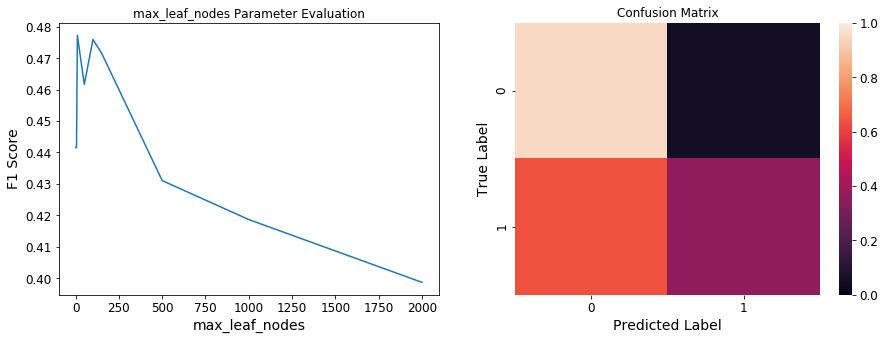

In [17]:
evaulate_parameter('max_leaf_nodes', [None, 2, 5, 10, 50, 100, 150, 500, 1000, 2000]);

### Analysis

#### Criterion

Overall the **entropy** criterion had a slightly better cross validation score.

#### Max Depth

The best Max Depth was around **5**. There was a peak around this value then the test F1 score drops and plateaus around 50.

5 isn’t so deep that the model will overfit to the training set too much given the number of features.

#### Min Sample Split

The best percentage for minimum number of splits was about **7.2%** (or about ~ 1500 samples). There were 2 distinctive peaks around this percentage and the performance levels off with high min sample splits.


#### Min Sample Leaf

The best percentage for the minimum samples in a leaf was around **1.6%** (or ~340 samples).

Visually again there was a peak around this value then drop and level out as it increased.


#### Max Leaf Nodes:

The best score was found for **~10** maximum leaf nodes but there was also a similarly high peak a little over 240.


## 1. b) Random Seach All Parameter

Next we will use **RandomizedSearchCV** to find the best parameter set all together. This will be done in 3 stages:

1. Coarse grain search uses the earlier individual parameter results as a starting point for each parameter.

2. Finer grain search which limits the range down further based on the results of the coarse grain search.

3. Finest grain search which runs over a much smaller range to make sure we have the ideal parameter selection.

In [13]:
# Helper Methods

def tune_all_parameter(param_grid, _class=DecisionTreeClassifier,  X_train=X_train, y_train=y_train, **kwargs):
    """
    Runs on Cross Validation grid search on a single specified parameter over the provided parameter values
    and reports the the best parameter and best scores.
    
    Returns the grid search.
    """
    
    n_iter = kwargs.get("n_iter", 1000)
    n_jobs = kwargs.get("n_jobs", -1)
    verbose = kwargs.get("verbose", False)
    refit = kwargs.get("refit", True)
    
    decision_tree = _class(random_state=123)
    
    # Use a grid search with f1 score as the scoring metric and 3 fold cross validaton
    grid_search = RandomizedSearchCV(decision_tree, 
                               param_grid, cv=3, 
                               scoring="f1",
                               return_train_score=False,
                               n_iter=n_iter,
                               random_state=123,
                               verbose=verbose,
                               n_jobs = n_jobs,
                               refit=refit)
    grid_search.fit(X_train, y_train)
    
    print("The best parameters: {}".format(grid_search.best_params_))
    print("The best score: {}".format(grid_search.best_score_))
    
    return grid_search


from sklearn.exceptions import NotFittedError
def display_score(model, X_test=X_test, y_test=y_test):
    """
    Calculates the final score of a model using the held out training data.
    If the model was not prevoiusly fit will first fit the model with the train data.
    
    In addition to printing the f1-score always returns the trained model along with other methods such as
    precision and recall.    
    """
    try:
        test_predictions = model.predict(X_test)
    except NotFittedError:
        model.fit(X_train, y_train)
        test_predictions = model.predict(X_test)
    score = f1_score(y_test, test_predictions)
    recall = recall_score(y_test, test_predictions)
    precision = precision_score(y_test, test_predictions)
    accuracy = accuracy_score(y_test, test_predictions)
    
    
    print("The f1-score for the model is {}".format(score))
    return model, score, recall, precision, accuracy
    
def compare_best_to_default(best_model_grid,_class, model_name):
    """
    Compare a trained tuned model against the same model type using just the default parameters.
    
    Prints the score differences as well as plots side by side confusion matrix plots.
    """
    default_model = _class()
    print("Score for Default Parameters:")
    default_model, default_score, default_rec, default_prec, default_accuracy = display_score(default_model)
    print()
    
    print("Score for Tuned Parameters")
    best_model, score, recall, precision, accuracy = display_score(best_model_grid.best_estimator_)
    print()
    
    print('Confusion Matrix comparing default parameters to tuned parameters')
    plot_comparing_confusion_matricies(best_model, 
                                    default_model, 
                                    "{} Tuned Parameters".format(model_name), 
                                    "{} Default Parameters".format(model_name))
    return best_model, [score, recall, precision, accuracy], [default_score, default_rec, default_prec, default_accuracy]

def plot_random_cv_results(cv_results_, zoom=False):
    """
    Individually plots all the different parameters against their cross validation test scores
    """
    test_scores = cv_results_['mean_test_score']
    params = cv_results_['params']

    # Put all the parameters and scores into a dataframe so they are easier to use with seaborn
    _df = pd.DataFrame(params)
    _df['score'] = test_scores
    
    # Zoom is set only look at the samples in the top 25% of scores
    if zoom:
        _df = _df[_df['score'] >= _df['score'].describe()['50%']]
    
    
    top_value = _df.nlargest(1, 'score')['score'].max()
    top_df = _df[_df['score'] == top_value]

    for index, col in enumerate([c for c in _df.columns if c not in ['is_top', 'score']]):
        
        # Discrete parameters like criterion will be plotted on a scatter while continuous will be
        # plotted on a jointplot
        discrete = all(isinstance(item, str) for item in _df[col]) or isinstance(_df[col][0], np.bool_)

        if not discrete:
            grid = sns.jointplot(data=_df, 
                                 x=col, 
                                 y='score', 
                                 alpha=0.5, 
                                 marginal_kws=dict(bins=40, rug=False))
            grid.fig.set_figwidth(15)
            grid.fig.set_figheight(2.5)
            grid.x = top_df[col]
            grid.y = top_df['score']
            grid.plot_joint(plt.scatter, marker='x', c='g', s=50)
        else:
            fig, ax = plt.subplots(figsize=(14, 2.5))
            for val in np.unique(_df[col]):
                
                if True == True:
                    scores = _df[_df[col] == val]['score']
                    ax = sns.distplot(scores,
                                      label="{} = {}".format(col, val), 
                                      ax=ax
                                     )
                    ax.legend()

    plt.subplots_adjust(hspace = 0.5)
    plt.show()
    
def plot_comparing_confusion_matricies(model_1, model_2, title_1, title_2):
    fig, ax = plt.subplots(ncols=2, figsize=(15,5))
    plot_confusion_matrix(model_1, X_test=X_test, y_test=y_test,ax=ax[0])
    ax[0].set_title(title_1)
    plot_confusion_matrix(model_2, X_test=X_test, y_test=y_test, ax=ax[1])
    ax[1].set_title(title_2);

### Coarse

Do a coarser grain search but s the parameters centered around or within range of those found in the individual paramter search.

The best parameters: {'criterion': 'gini', 'max_depth': 18, 'max_leaf_nodes': 44, 'min_samples_leaf': 0.02320846074940041, 'min_samples_split': 0.046645408791708795}
The best score: 0.4850452437407439


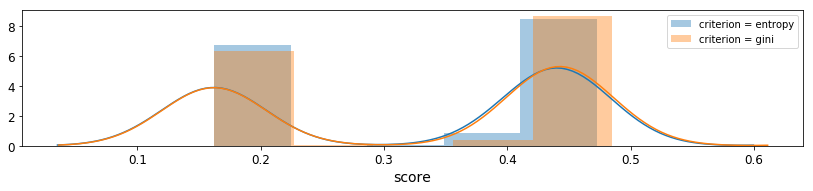

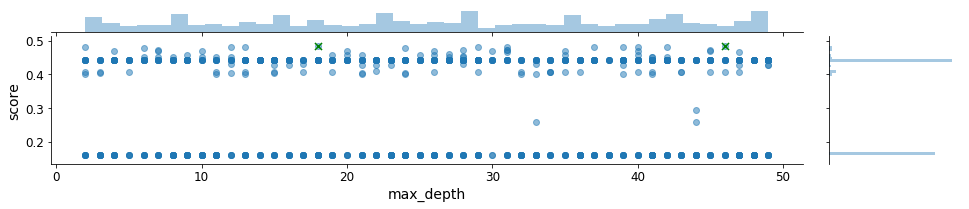

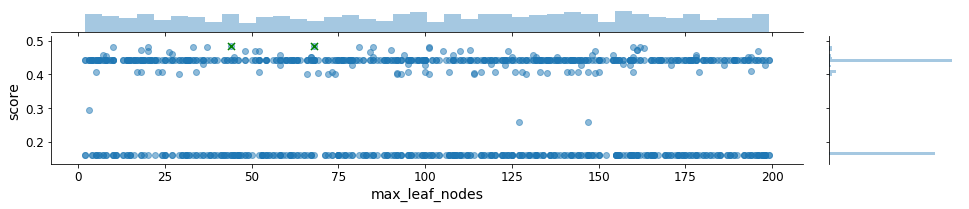

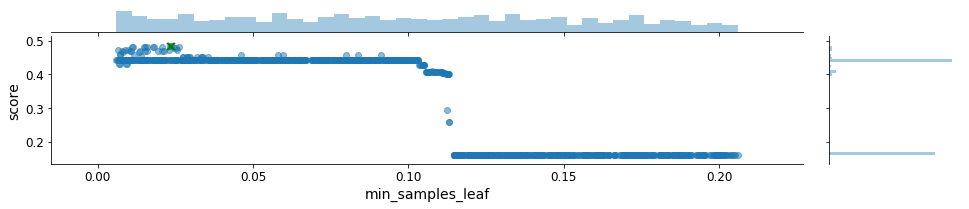

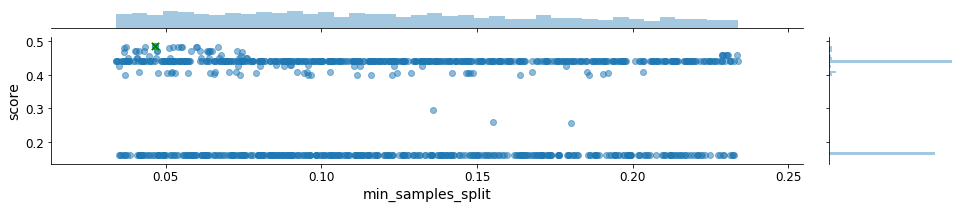

In [19]:
param_grid = {
    "criterion": ["gini", "entropy"],
    'max_depth': sp_randint(2, 50),
    'min_samples_split': stats.truncnorm(a=0.000001, b=1, loc=0.034, scale=0.2),
    'min_samples_leaf': stats.truncnorm(a=0.000001, b=1, loc=0.006, scale=0.2),
    'max_leaf_nodes': sp_randint(2, 200)
    }

coarse_resulting_grid = tune_all_parameter(param_grid);
plot_random_cv_results(coarse_resulting_grid.cv_results_)

### Observations

Looks like we can narrow in a little more on *min_samples_leaf* and *min_samples_split*

### Finer Grain

The best parameters: {'criterion': 'gini', 'max_depth': 19, 'max_leaf_nodes': 141, 'min_samples_leaf': 0.02368956438476186, 'min_samples_split': 0.03985783117571593}
The best score: 0.4850452437407439


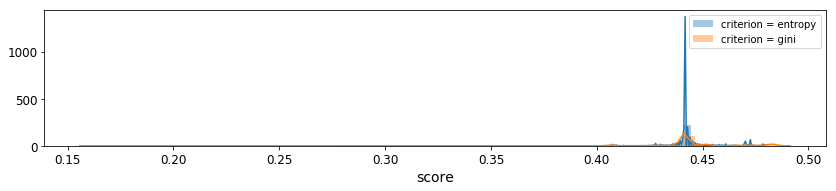

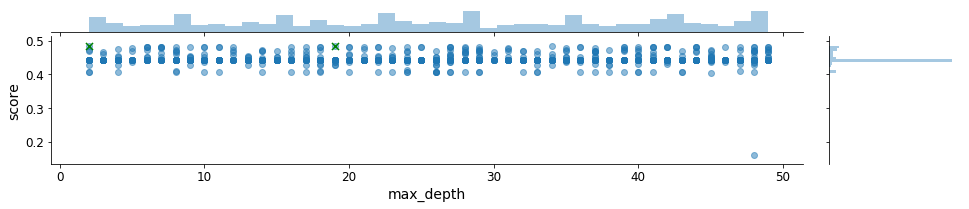

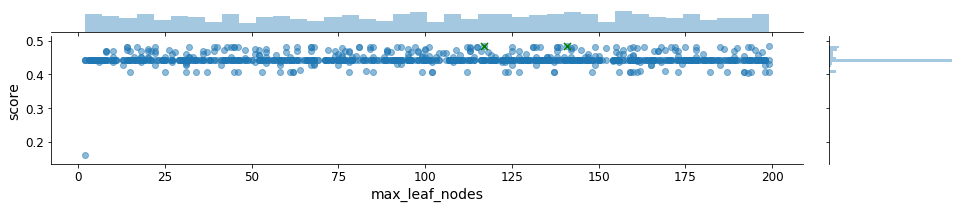

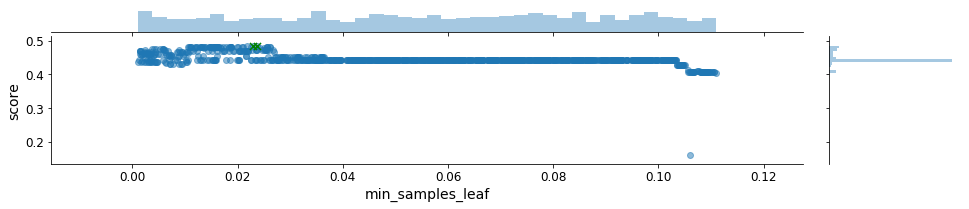

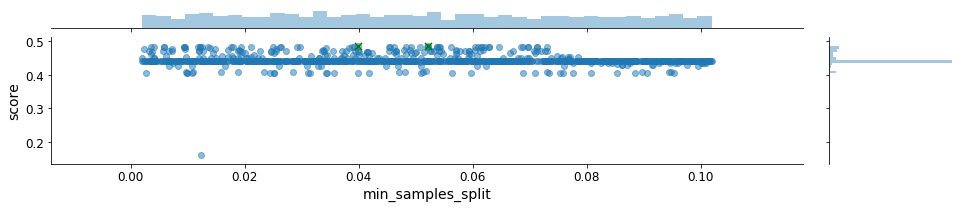

In [20]:
param_grid = {
    "criterion": ["gini", "entropy"],
    'max_depth': sp_randint(2, 50),
    'min_samples_split': stats.uniform(0.002, 0.1),
    'min_samples_leaf': stats.uniform(0.001, 0.11),
    'max_leaf_nodes': sp_randint(2, 200)
    }


finer_resulting_grid = tune_all_parameter(param_grid);
plot_random_cv_results(finer_resulting_grid.cv_results_)

We are closer but still can zoom in more on *min_samples_left*.

For the last search we will also go with the *gini* criterion because it has shown better results in the Coarse and Finer searches.

## Finest Grain

The best parameters: {'criterion': 'gini', 'max_depth': 50, 'max_leaf_nodes': 151, 'min_samples_leaf': 0.02285412778560477, 'min_samples_split': 0.05627078840214894}
The best score: 0.4850452437407439


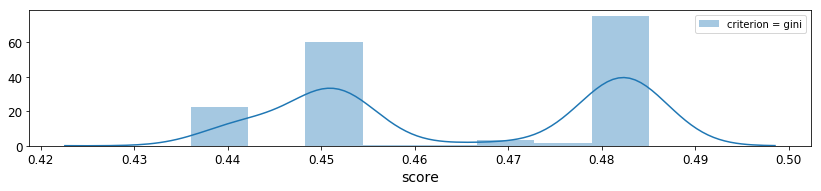

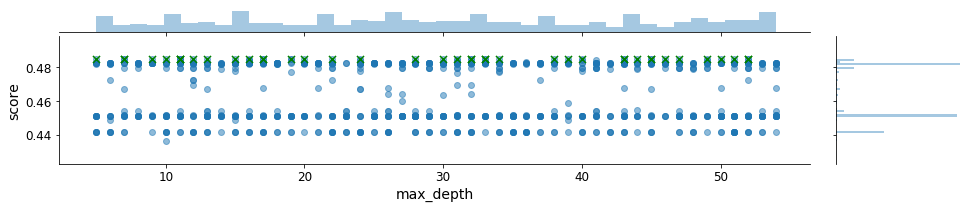

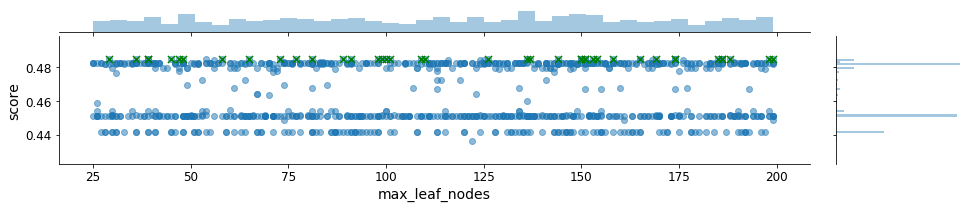

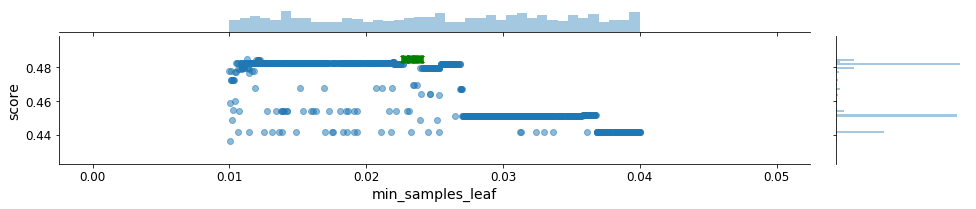

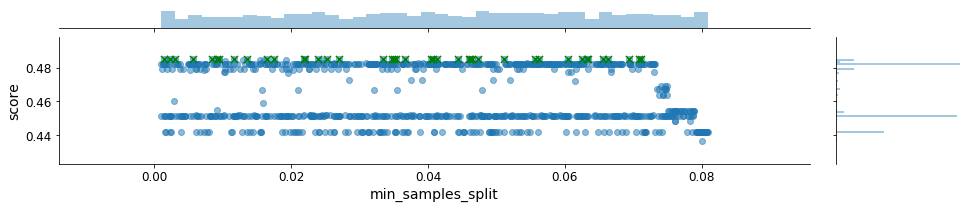

In [21]:
param_grid = {
    "criterion": ["gini"],
    'max_depth': sp_randint(5, 55),
    'min_samples_split': stats.uniform(0.001, 0.08),
    'min_samples_leaf': stats.uniform(0.01, 0.03), 
    'max_leaf_nodes': sp_randint(25, 200)
    }


finest_resulting_grid = tune_all_parameter(param_grid);
plot_random_cv_results(finest_resulting_grid.cv_results_)

### Observations

The best parameters: 

*criterion*: 'gini'

*max_depth*: 50

*max_leaf_nodes*:151

*min_samples_leaf*: 0.02285412778560477

*min_samples_split*: 0.05627078840214894

Interestingly our best models ended up picking *gini* over *entropy* for the **criterion** despite *entropy* performing better in isolation.

The **max deapth** and **max_leaf_nodes** were a little higher than the individual search but the **min_sample_split** and **min_sample_leaf** were within a fairly close range to their individual optimization.

## Final Model

Next let's compare the final performance of the tuned model on the heldout test set against the DecisionTreeClassifer with the default parameters.

Score for Default Parameters:
The f1-score for the model is 0.39727361246348586

Score for Tuned Parameters
The f1-score for the model is 0.4869009584664537

Confusion Matrix comparing default parameters to tuned parameters


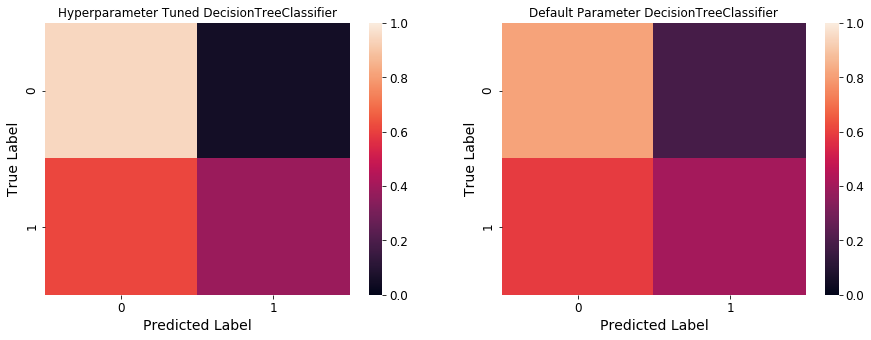

In [22]:
best_model, _, _ = compare_best_to_default(finest_resulting_grid, DecisionTreeClassifier, "DecisionTreeClassifier");

### Conclusions

The hyperparamer tuned model had a much higher f-score compared to the model with the default parameters (0.486 > 0.397).

We can see from the confusion matrix the tuned model was much better at predicting individuals who did not default by reducing the False Positives.

## Features

We can look to see what features the model found most important.

In [28]:
def display_feature_importance(model):
    fi_df = pd.DataFrame([model.feature_importances_, X_train.columns]).T
    fi_df.columns = ['Importance Score', 'Feature']
    fi_df = fi_df.sort_values(by='Importance Score', ascending=False)
    return fi_df

In [24]:
display_feature_importance(best_model)

,Importance Score,Feature
5,0.688758,PAY_0
6,0.14728,PAY_2
19,0.0472221,PAY_AMT3
0,0.0275196,LIMIT_BAL
7,0.0212461,PAY_3
11,0.0206511,BILL_AMT1
10,0.0124133,PAY_6
9,0.00956413,PAY_5
12,0.00927856,BILL_AMT2
20,0.00683778,PAY_AMT4


By far the most important feature was **PAY_0** followed by **PAY_2**.

Many of the personal information like Age, Marriage, Sex had a feature importance score of 0 so were not useful for the model.

### Ensemble Learning

Make sure to read and understand the documentation for each classifier.

Remember to make your code modular; it will save you rewriting the same things multiple times and will help avoid copy paste errors.


  
- Tune the following classifiers:
  - Random forest classfier
  - Adaboost Tree classifier
  - Extra trees classifier
  - Gradient Boosted Tree classifier
  - Logistic Regression
  
- Analyze, compare, and interpret your results
- What ensemble yields the best result? Can you identify certain types of events that are classified better/worse from the type of algorithm?
- Is the feature importance consistent for all classifiers?

## Tuning Classifiers

For each of the above classifiers we will now try to tune an optimized model the compare the results.

The below code shows the finer tuning to reduce the size of the notebook but the numbers in the cells were derviced
by performing similar steps as with the DecisionTreeClassifier. First individually tune each parameter to get a range and all together narrow in the ranges.

### Random Forest Classifier

The best parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 15, 'max_features': 19, 'max_leaf_nodes': 1014, 'min_samples_leaf': 0.0030296827628110644, 'min_samples_split': 0.06874710506286799, 'n_estimators': 944}
The best score: 0.4730241432724539


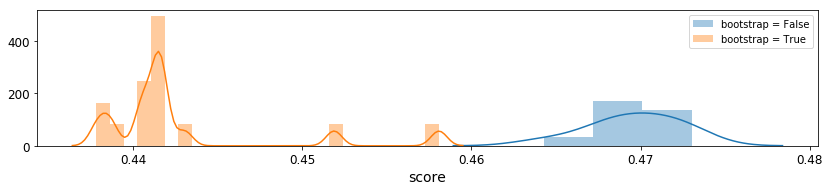

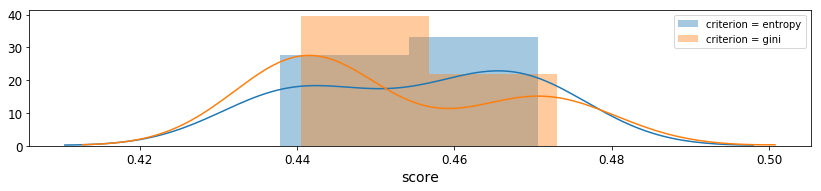

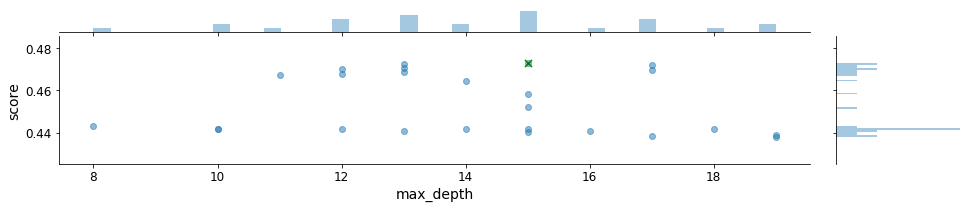

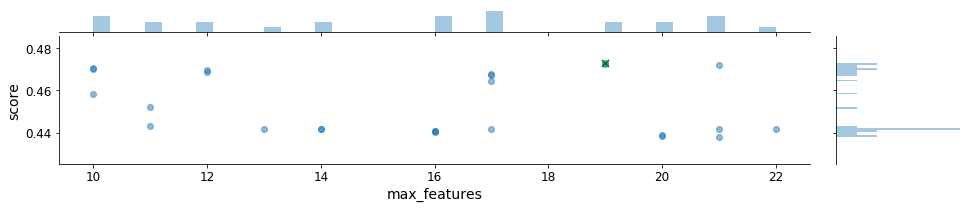

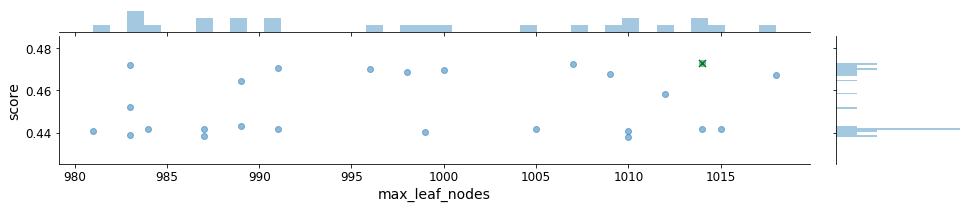

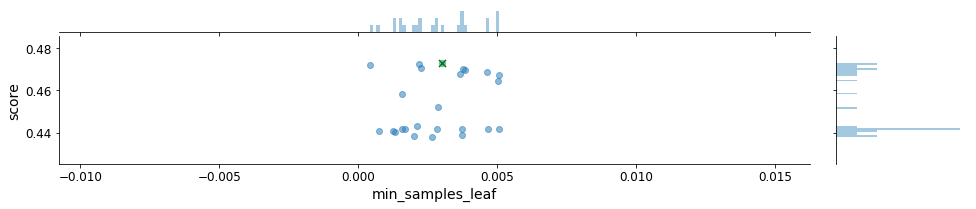

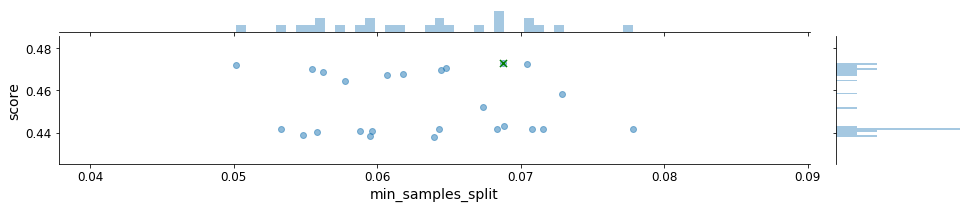

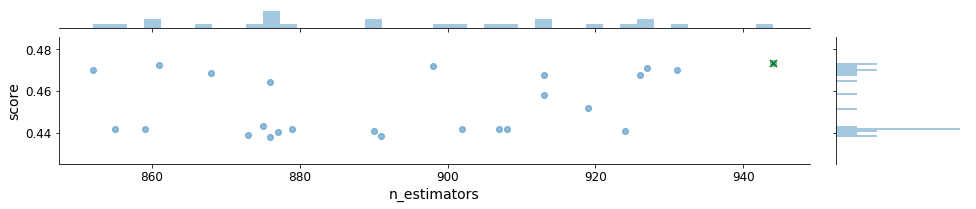

In [14]:
random_forest = RandomForestClassifier(random_state=123)

param_grid = {
    "criterion": ["entropy", "gini"],
    "n_estimators": stats.randint(850,950),
    "max_leaf_nodes": stats.randint(980,1020),
    "max_depth": stats.randint(8,20),
    "min_samples_split": stats.uniform(0.05, 0.03),
    "min_samples_leaf": stats.uniform(0.0001, 0.005),
    "bootstrap": [True, False],
    "max_features": stats.randint(10, X_train.shape[1] + 1)
    }

random_forest_grid = tune_all_parameter(param_grid, RandomForestClassifier, n_iter=25, n_jobs=5, verbose=False);
plot_random_cv_results(random_forest_grid.cv_results_)

Score for Default Parameters:
The f1-score for the model is 0.41094062708472323

Score for Tuned Parameters
The f1-score for the model is 0.46582614465826144

Confusion Matrix comparing default parameters to tuned parameters


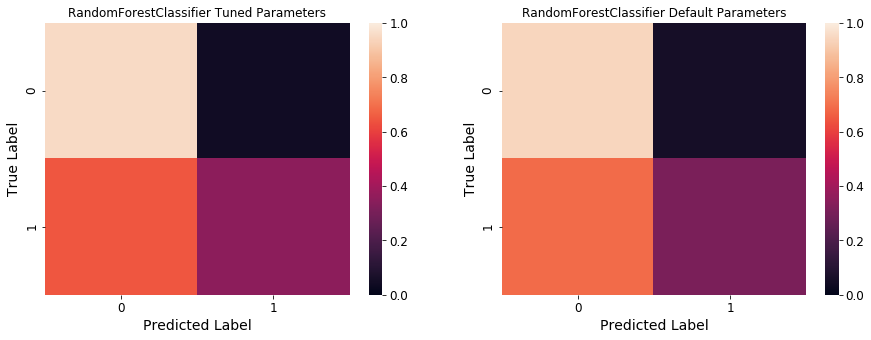

In [15]:
best_rf_model, rf_best_scores, rf_default_scores = compare_best_to_default(random_forest_grid, RandomForestClassifier, "RandomForestClassifier")

## Adaboost Trees

The best parameters: {'algorithm': 'SAMME', 'learning_rate': 1.1997538131519225, 'n_estimators': 545}
The best score: 0.44741522936732636


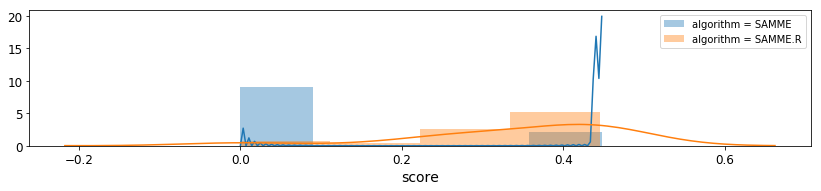

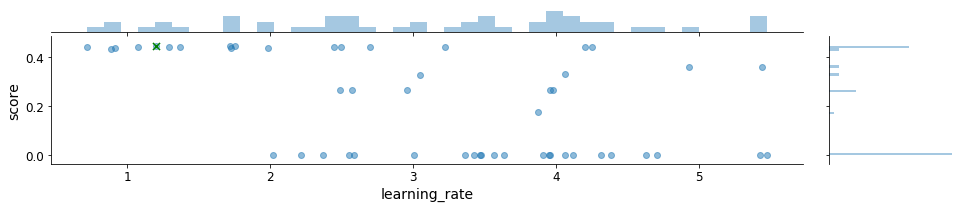

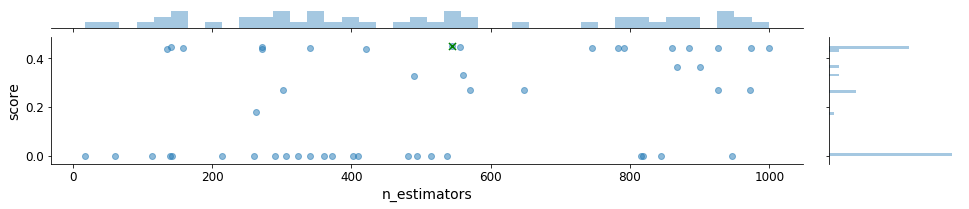

In [16]:
param_grid = {
    "n_estimators": stats.randint(1, 1000),
    "learning_rate": stats.uniform(0.5,5),
    "algorithm": ["SAMME", "SAMME.R"]
    }

adaboost_grid = tune_all_parameter(param_grid, AdaBoostClassifier, n_iter=50, n_jobs=5, versbose=False);
plot_random_cv_results(adaboost_grid.cv_results_)

Score for Default Parameters:
The f1-score for the model is 0.42758620689655175

Score for Tuned Parameters
The f1-score for the model is 0.45187165775401067

Confusion Matrix comparing default parameters to tuned parameters


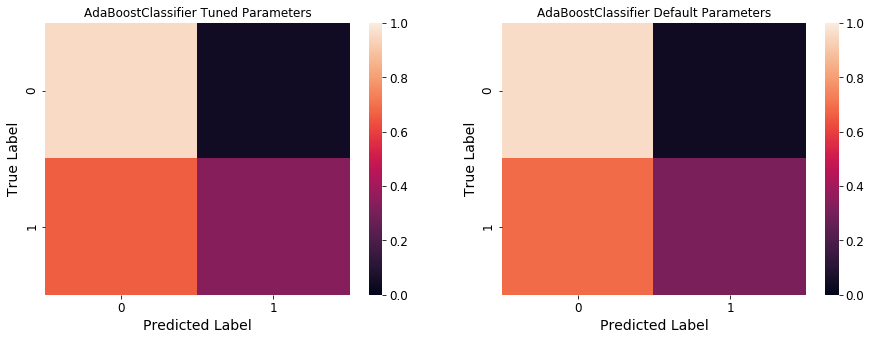

In [17]:
best_ada_model, ada_best_scores, ada_default_scores = compare_best_to_default(adaboost_grid, AdaBoostClassifier, 'AdaBoostClassifier')

## Extra Tree Classifier Classifier

The best parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 16, 'max_features': 20, 'max_leaf_nodes': 1386, 'min_samples_leaf': 0.0006760896275024644, 'min_samples_split': 0.06288378870733802, 'n_estimators': 23}
The best score: 0.4791832198980006


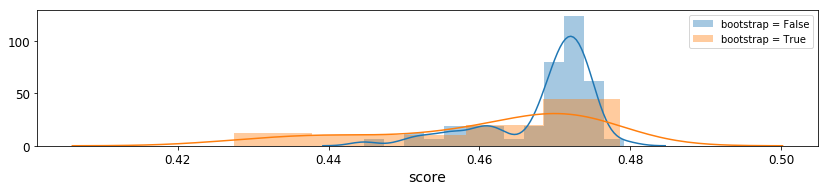

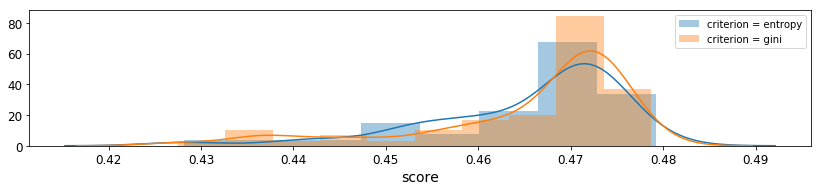

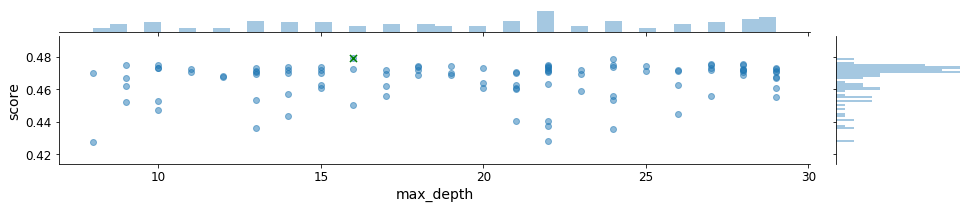

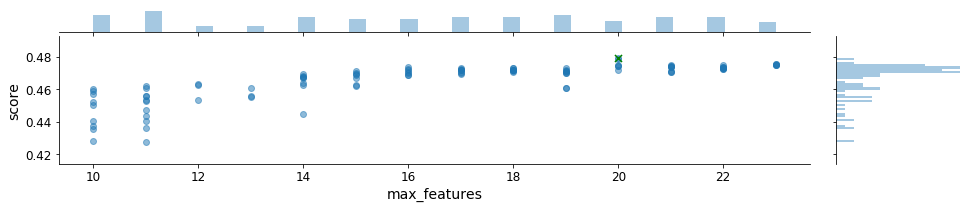

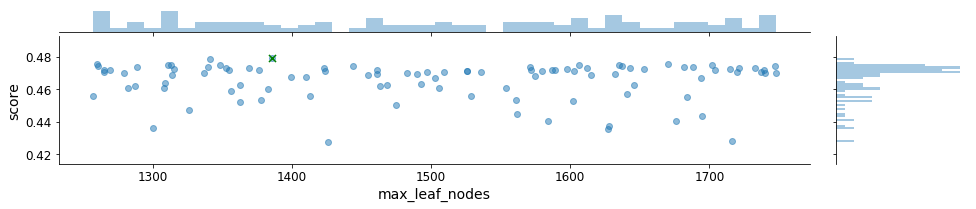

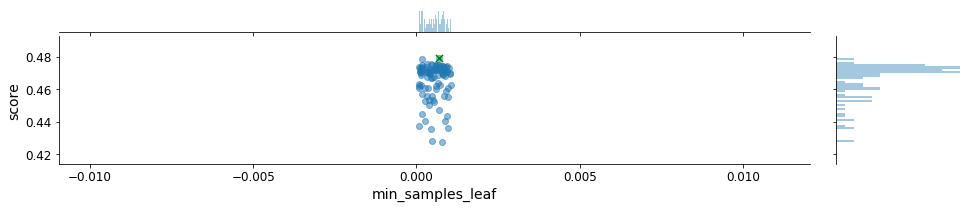

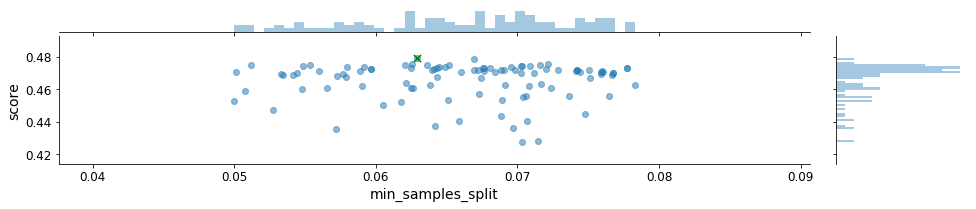

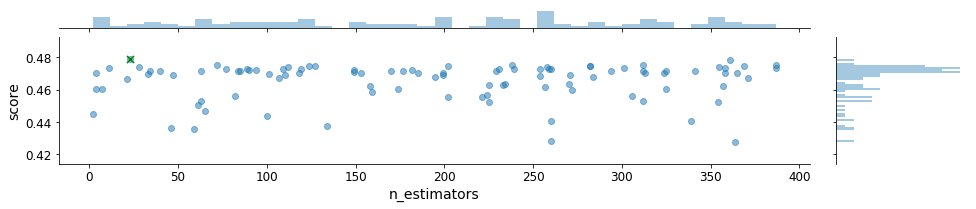

In [18]:
param_grid = {
    "criterion": ["entropy", "gini"],
    "n_estimators": stats.randint(1,400),
    "max_leaf_nodes": stats.randint(1250,1750),
    "max_depth": stats.randint(8,30),
    "min_samples_split": stats.uniform(0.05, 0.03),
    "min_samples_leaf": stats.uniform(1/X_train.shape[0], 0.001),
    "bootstrap": [True, False],
    "max_features": stats.randint(10, X_train.shape[1] + 1)
    }

extra_tree_grid = tune_all_parameter(param_grid, ExtraTreesClassifier, n_iter=100, n_jobs=5, verbose=False);
plot_random_cv_results(extra_tree_grid.cv_results_)

Score for Default Parameters:
The f1-score for the model is 0.41563517915309445

Score for Tuned Parameters
The f1-score for the model is 0.4740932642487046

Confusion Matrix comparing default parameters to tuned parameters


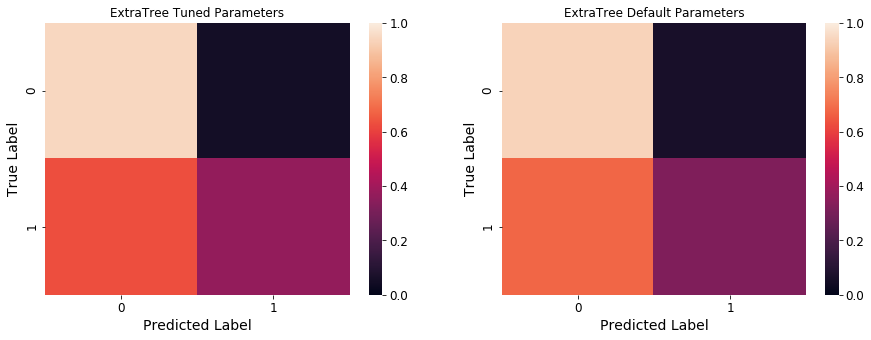

In [19]:
best_extra_model, extra_best_scores, extra_default_scores = compare_best_to_default(extra_tree_grid, ExtraTreesClassifier, "ExtraTree")

## Gradient Boosted Tree Classifier

The best parameters: {'criterion': 'mse', 'learning_rate': 0.07745273508386954, 'loss': 'deviance', 'max_depth': 7, 'max_features': 21, 'max_leaf_nodes': 10, 'min_samples_leaf': 0.0015715347277707808, 'min_samples_split': 0.06353265038659625, 'n_estimators': 87, 'subsample': 0.48421096160512067}
The best score: 0.48256855189592757


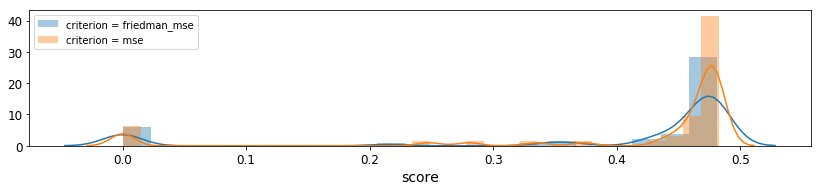

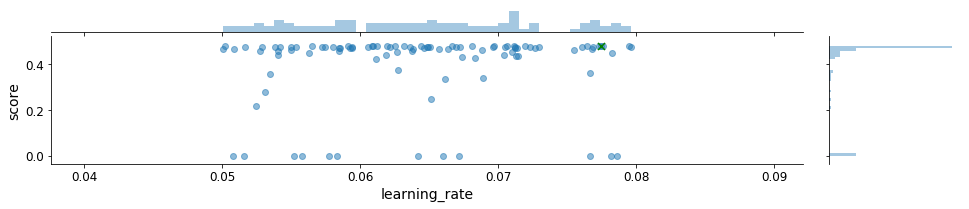

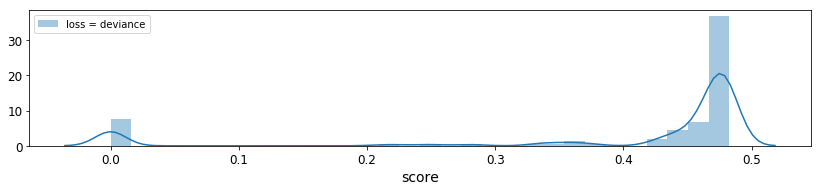

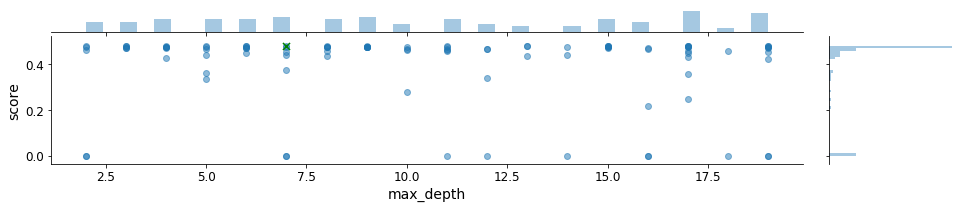

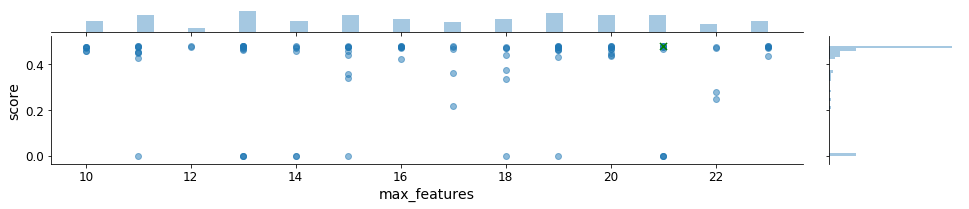

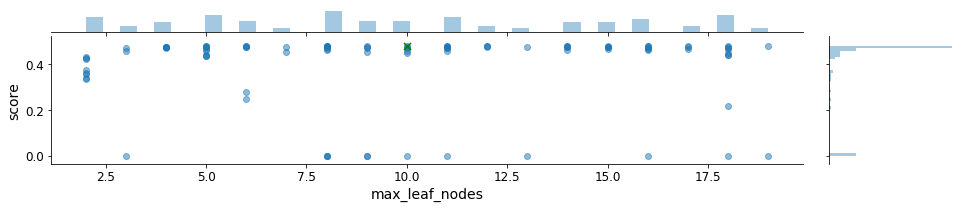

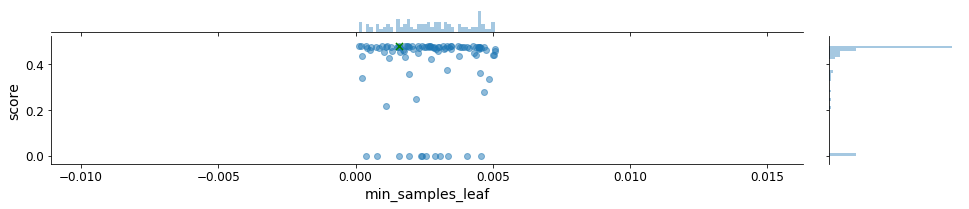

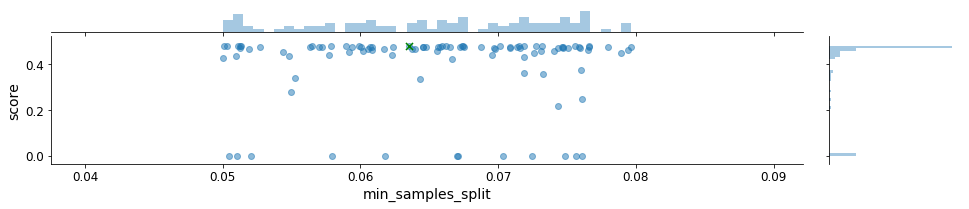

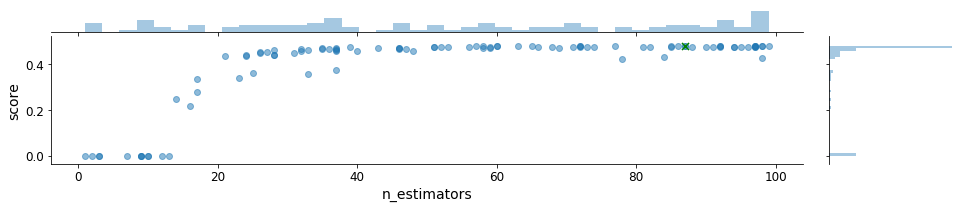

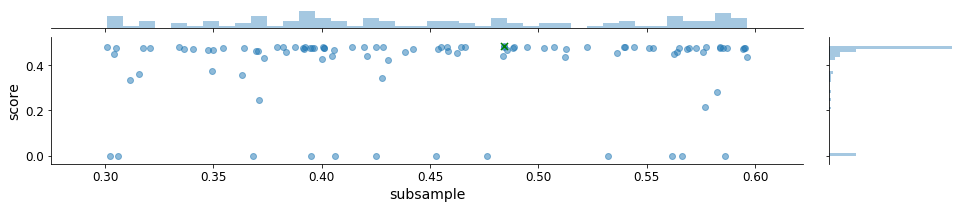

In [20]:
param_grid = {
    "n_estimators": stats.randint(1, 100),
    "loss" : ["deviance"],  #exponential always did far worse
    "criterion": ["friedman_mse", "mse"],
    "learning_rate": stats.uniform(0.05, 0.03),
    "max_features": stats.randint(10, X_train.shape[1] + 1),
    "max_leaf_nodes": stats.randint(2,20),
    "max_depth": stats.randint(2,20),
    "min_samples_split": stats.uniform(0.05, 0.03),
    "min_samples_leaf": stats.uniform(0.0001, 0.005),
    "subsample": stats.uniform(0.3,0.3)
    }

grad_boost_grid = tune_all_parameter(param_grid, GradientBoostingClassifier, n_iter=100, n_jobs=5, versbose=False);
plot_random_cv_results(grad_boost_grid.cv_results_)

Score for Default Parameters:
The f1-score for the model is 0.47174770039421815

Score for Tuned Parameters
The f1-score for the model is 0.48551191242755953

Confusion Matrix comparing default parameters to tuned parameters


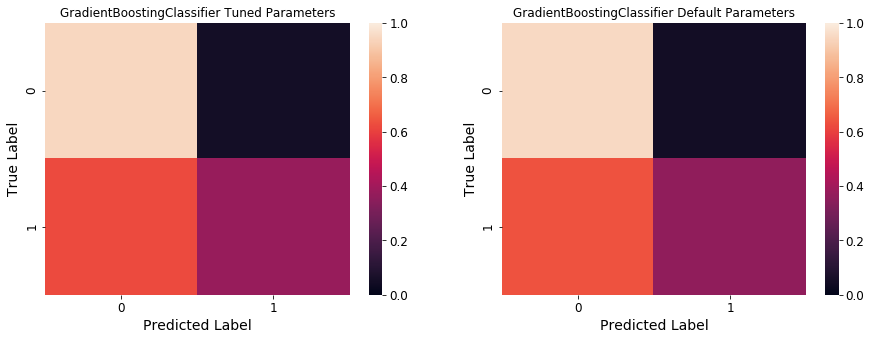

In [21]:
best_grad_model, grad_best_scores, grad_default_scores = compare_best_to_default(grad_boost_grid, GradientBoostingClassifier, 'GradientBoostingClassifier')

## Logistical Regression

The best parameters: {'C': 0.24123679015859145, 'max_iter': 114, 'penalty': 'l2', 'solver': 'newton-cg'}
The best score: 0.354517942818839


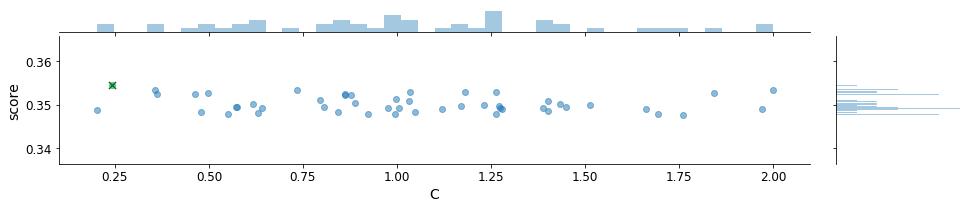

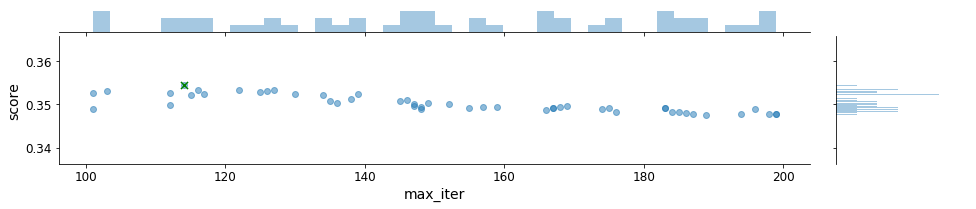

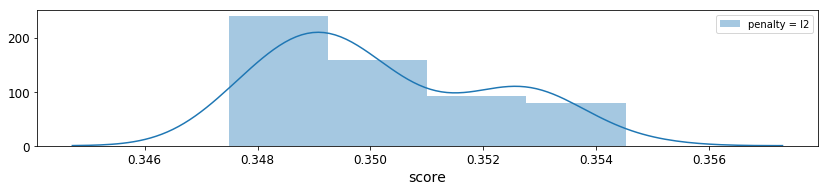

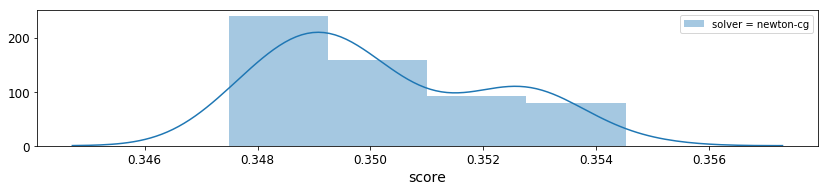

In [22]:
param_grid = {
    "penalty": ["l2"], # l1 performs far better for liblinear but overall newton-cg performs best
    "C": stats.uniform(0.01, 2),
    "solver": ["newton-cg"],
    "max_iter": stats.randint(100, 200)

    }

log_reg_grid = tune_all_parameter(param_grid, LogisticRegression, n_iter=50, n_jobs=5, verbose=False);
plot_random_cv_results(log_reg_grid.cv_results_)

Score for Default Parameters:
The f1-score for the model is 0.002002002002002002

Score for Tuned Parameters
The f1-score for the model is 0.3434650455927052

Confusion Matrix comparing default parameters to tuned parameters


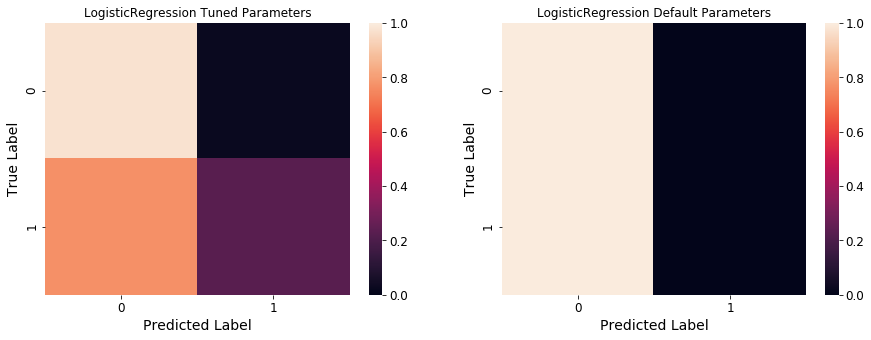

In [23]:
best_log_model, log_best_scores, log_default_scores = compare_best_to_default(log_reg_grid, LogisticRegression, "LogisticRegression")

## Comparision of Models

In [24]:
def highlight_max(data):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'font-weight: {}'.format('bold')
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)
    
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color

In [25]:
comp_data = [
    rf_best_scores + rf_default_scores + ['RandomForestClassifier'],
    ada_best_scores + ada_default_scores + ['AdaBoostClassifier'],
    extra_best_scores + extra_default_scores + ['ExtraTreesClassifier'],
    grad_best_scores + grad_default_scores + ['GradientBoostingClassifier'],
    log_best_scores + log_default_scores + ['LogisticRegression']
]
comp_df = pd.DataFrame(comp_data, 
                       columns=['F1 Score', 'Recall', 'Precision', 'Accuracy', 
                                'Default F1 Score', 'Default Recall', 'Default Precision', 'Default Accuracy',
                               'Model Type'])


comp_df['Default_F1_Delta'] = comp_df['F1 Score'] - comp_df['Default F1 Score']
comp_df['Default_Recall_Delta'] = comp_df['Recall'] - comp_df['Default Recall']
comp_df['Default_Precision_Delta'] = comp_df['Precision'] - comp_df['Default Precision']
comp_df['Default_Accuracy_Delta'] = comp_df['Accuracy'] - comp_df['Default Accuracy']

comp_df = comp_df[['Model Type', 'F1 Score', 'Recall', 'Precision', 'Accuracy', 'Default_F1_Delta', 
                   'Default_Recall_Delta', 'Default_Precision_Delta', 'Default_Accuracy_Delta']]

comp_df = comp_df.sort_values(by='F1 Score', ascending=False)
comp_df = comp_df.set_index('Model Type')
cm = sns.light_palette("green", as_cmap=True)

s_comp_df = comp_df.style.background_gradient(cmap=cm).applymap(color_negative_red).apply(highlight_max)
s_comp_df

,F1 Score,Recall,Precision,Accuracy,Default_F1_Delta,Default_Recall_Delta,Default_Precision_Delta,Default_Accuracy_Delta
Model Type,,,,,,,,
GradientBoostingClassifier,0.485512,0.378894,0.675627,0.822444,0.0137642,0.0180905,-0.00558718,0.00111111
ExtraTreesClassifier,0.474093,0.367839,0.666667,0.819556,0.0584581,0.0472362,0.0759259,0.0188889
RandomForestClassifier,0.465826,0.352764,0.685547,0.821111,0.0548855,0.0432161,0.0744358,0.0173333
AdaBoostClassifier,0.451872,0.339698,0.674651,0.817778,0.0242855,0.0281407,-0.00666798,0.00222222
LogisticRegression,0.343465,0.227136,0.70405,0.808,0.341463,0.226131,0.45405,0.0295556


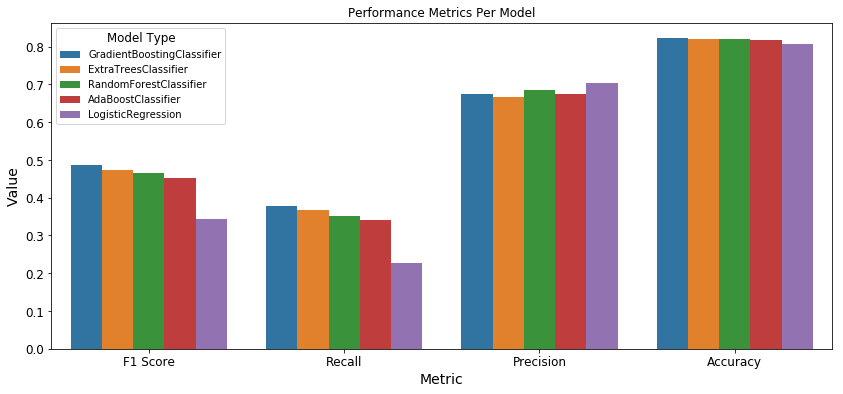

In [104]:
s = comp_df[['F1 Score', 'Recall', 'Precision', 'Accuracy']].stack()
s = s.to_frame().reset_index()
s.columns = ["Model Type", "Metric", "Value"]
f, ax = plt.subplots(figsize=(14, 6))
sns.barplot(data=s, x='Metric', y='Value', hue="Model Type");
ax.set_title("Performance Metrics Per Model");

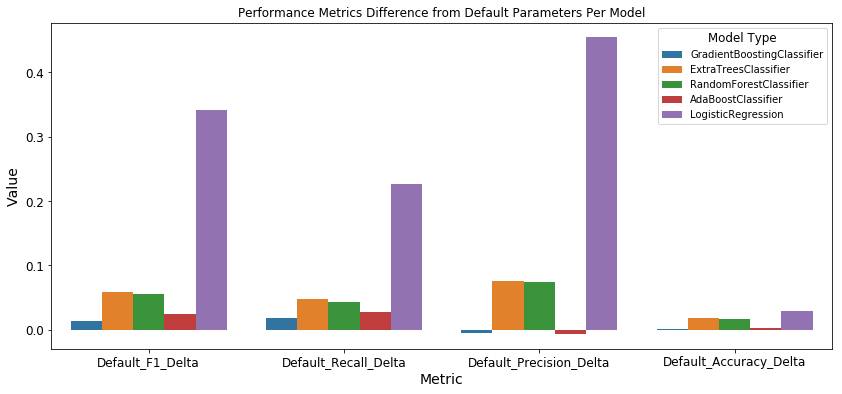

In [113]:
s = comp_df[['Default_F1_Delta', 'Default_Recall_Delta', 'Default_Precision_Delta', 'Default_Accuracy_Delta']].stack()
s = s.to_frame().reset_index()
s.columns = ["Model Type", "Metric", "Value"]
f, ax = plt.subplots(figsize=(14, 6))
sns.barplot(data=s, x='Metric', y='Value', hue="Model Type");
ax.set_title("Performance Metrics Difference from Default Parameters Per Model");

### Overall

Overall the **GradientBoostingClassifier** for the highest *F1 score* as well as the highest *recall* and *acuracy* making it probably the best overall classifier.

**LogisticRegression** despite having the lowest F1 score and recall had the highest *precision*.

### Models vs Default Parameters

When compared against their default models as expected all 5 models had their F1 Score increase as this was the precision metric used to tune the models. However all 5 models also had their recall and accuracy scores increase as well. Precision went up for **ExtraTreesClassifier**, **RandomForestClassifier**, and signficantly for **LogisticRegression** but went down very slightly for **GradientBoostingClassifier** and **AdaBoostClassifier**.

As F1 score was used to tune the parameters it's possible for the precision score to go down as long as the recall went up enough to compensate.

Overall **LogisticRegression** received the most benefits from the hyper parameter tuning compared to the other models.

### Type of Events

The **LogisticRegression** model with its high precision and low recall seemed very good at not classifying False Positives but missed many True Postiives in the process.

The other 3 models were a little more balanced but did have a higher recall than **LogisticRegression** so they didn't seem to overclassify as many False Negatives. 


## Features

In [26]:
# For logistic regression we need to extract the feature importance from the coefficients
log_df = pd.DataFrame(np.abs(np.std(X_train, 0).values*best_log_model.coef_), columns=X_train.columns).T
log_df['Model Type'] = "LogisticRegression"
log_df.columns = ['Importance Score', 'Model Type']
log_df['Feature'] = log_df.index

In [29]:
features = [display_feature_importance(model) for model in [best_rf_model, best_grad_model, best_ada_model, best_extra_model]]
features[0]['Model Type'] = "Random Forest Classifier"
features[1]['Model Type'] = "Gradient Boosted Classifier"
features[2]['Model Type'] = "AdaBoostClassifier"
features[3]['Model Type'] = "ExtraTreeClassifier"
fs_df = pd.concat(features + [log_df], sort=False)
fs_df = fs_df.pivot(index='Model Type', columns='Feature', values='Importance Score').T

fs_df = fs_df.applymap('{:.3f}'.format)
fs_df = fs_df.apply(pd.to_numeric)
fs_df['Average'] = fs_df.mean(axis=1)
fs_df = fs_df.sort_values(by='Average', ascending=False)

s_fs_df = fs_df.style.background_gradient(cmap=cm).apply(highlight_max)

s_fs_df

Model Type,AdaBoostClassifier,ExtraTreeClassifier,Gradient Boosted Classifier,LogisticRegression,Random Forest Classifier,Average
Feature,,,,,,
PAY_0,0.327,0.414,0.432,0.616,0.618,0.4814
PAY_2,0.032,0.268,0.176,0.124,0.193,0.1586
BILL_AMT1,0.057,0.007,0.039,0.553,0.017,0.1346
PAY_AMT2,0.055,0.005,0.022,0.29,0.012,0.0768
BILL_AMT2,0.03,0.006,0.018,0.29,0.007,0.0702
PAY_AMT1,0.068,0.008,0.02,0.22,0.007,0.0646
PAY_3,0.035,0.061,0.05,0.077,0.04,0.0526
PAY_4,0.038,0.098,0.03,0.06,0.013,0.0478
LIMIT_BAL,0.039,0.032,0.035,0.106,0.024,0.0472


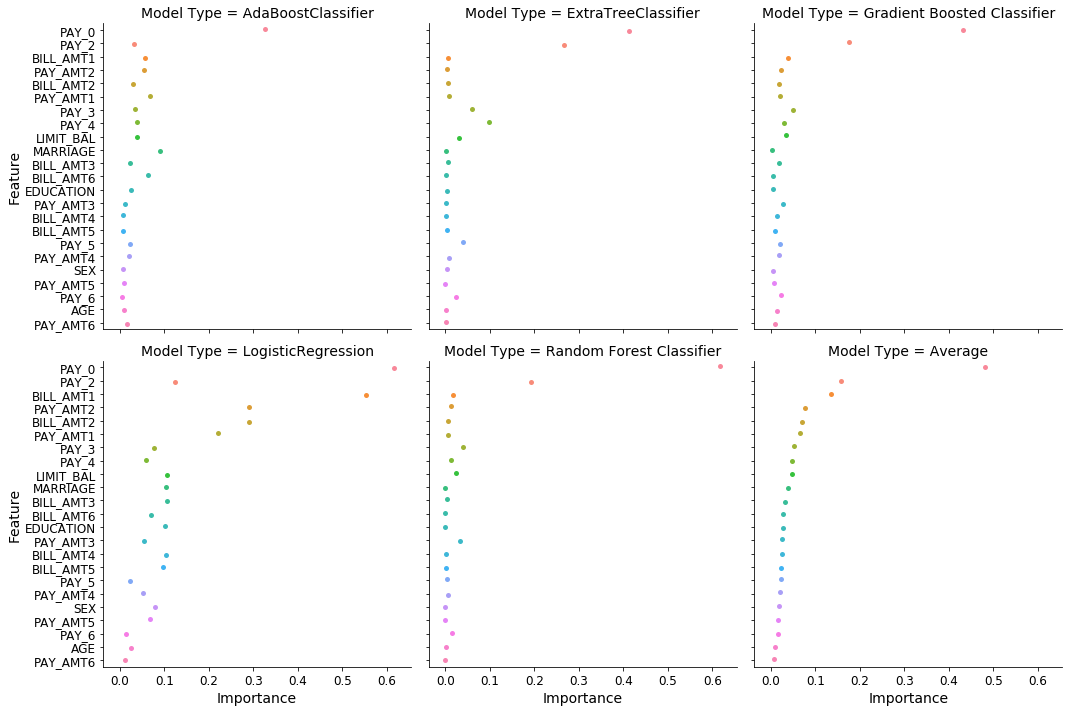

In [85]:
s = fs_df.stack()
s = s.to_frame().reset_index()
s.columns = ["Feature", "Model Type", 'Importance']
sns.catplot(data=s, y='Feature', x='Importance', col="Model Type", col_wrap=3)

All the models by far had the most important feature of **PAY_0**.

Otherwise most of the ensemble models had similar feature importances with all the models except AdaBoostClassifier putting extra importance on **PAY_2**.

The model with the most different feature importance was **LogisticRegression** who ranked **BILL_AMT1** much higher than any of the other models.


- Stack your models. 
  - Combine the models from the previous section using the stacking approach: 
    - Choose the model use to combine. Examples are:
      - Linear Regression
      - Logistic Regression

The best parameters: {'alpha': 0.0017269974551904154, 'l1_ratio': 0.6297276340470472, 'max_iter': 1000, 'penalty': 'l1', 'tol': 0.001}
The best score: 0.3677820460521493


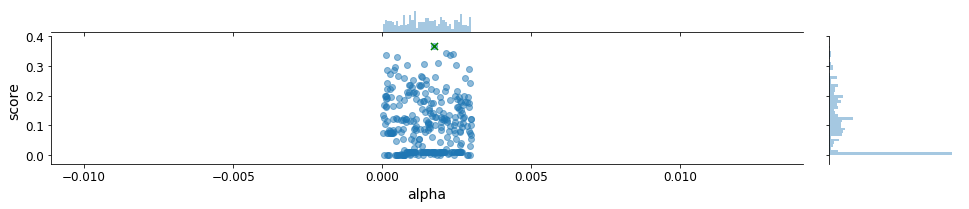

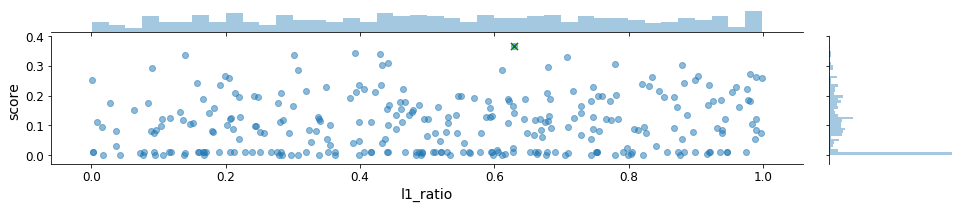

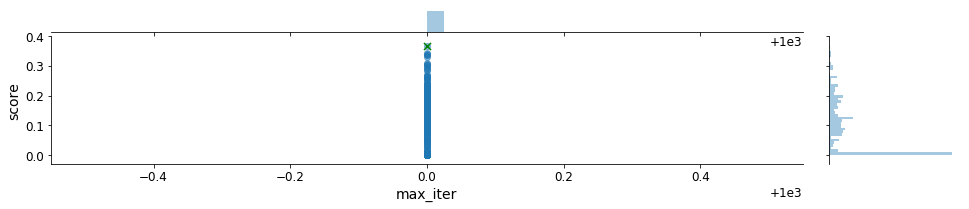

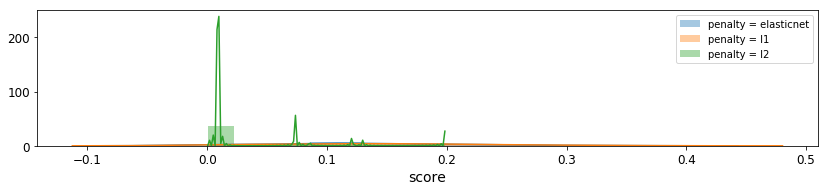

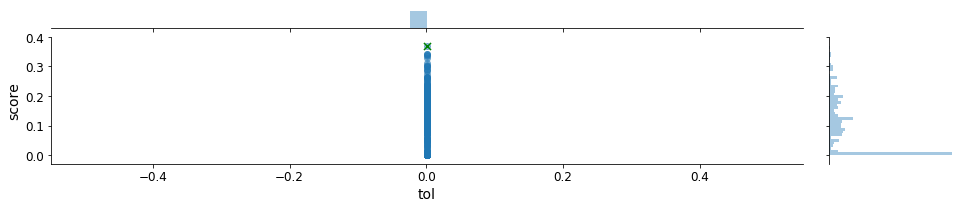

In [30]:
linear_classifier = SGDClassifier()
linear_classifier.fit(X_train, y_train)

param_grid = {
    "penalty": ["l1","l2", "elasticnet"], # l1 performs far better for liblinear but overall newton-cg performs best
    "alpha": stats.uniform(0.0000, 0.003),
    "l1_ratio": stats.uniform(0, 1),
    "max_iter":[1000],
    "tol":[1e-3]
    }

sgd_reg_grid = tune_all_parameter(param_grid, SGDClassifier, n_iter=300, n_jobs=5, verbose=False);
plot_random_cv_results(sgd_reg_grid.cv_results_)

Score for Default Parameters:
The f1-score for the model is 0.002

Score for Tuned Parameters
The f1-score for the model is 0.3615712257453857

Confusion Matrix comparing default parameters to tuned parameters


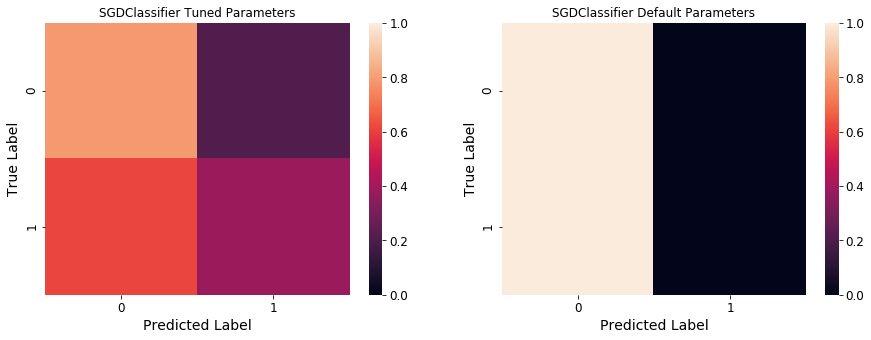

In [31]:
best_sgd_model, sgd_best_scores, sgd_default_scores = compare_best_to_default(sgd_reg_grid, SGDClassifier, 'SGDClassifier')

### Stacked Model Selection

For the stacked model approach we will keep all 5 of our models.

At a minimum we would have picked **LogisticRegression** and **GradientBoostingClassifier** since they seemed to behave the most differently.

We will use a **RandomForestClassifier** as the stacked model and iterate over the max_features.

#### Strategy

We look through all the models and create a new train set based on the held out stack set.

We will then train a new RandomForestClassifier this time on the newly created stack train set. 

Finally to measure the performance of the stacked RandomForestClassifier on the test set.

In [32]:
estimators = [best_sgd_model, best_rf_model, best_grad_model, best_ada_model, best_extra_model, best_log_model]

X_val_predictions = np.empty((len(X_stack), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_stack)


The best parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 85, 'max_features': 6, 'max_leaf_nodes': 98, 'min_samples_leaf': 0.10939023996740238, 'min_samples_split': 0.026317920176870506, 'n_estimators': 4}
The best score: 0.4850376090637464


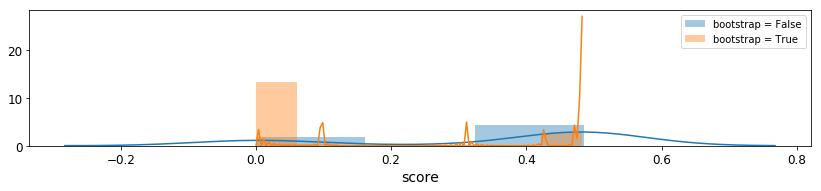

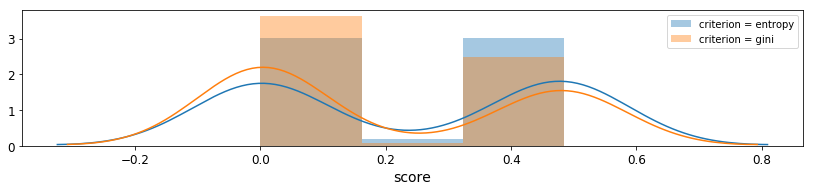

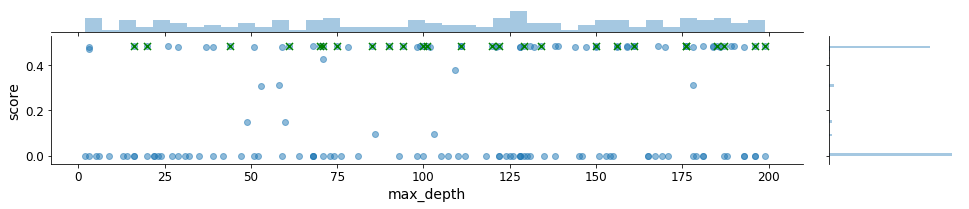

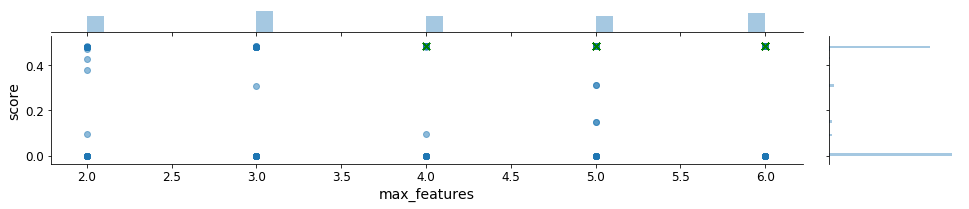

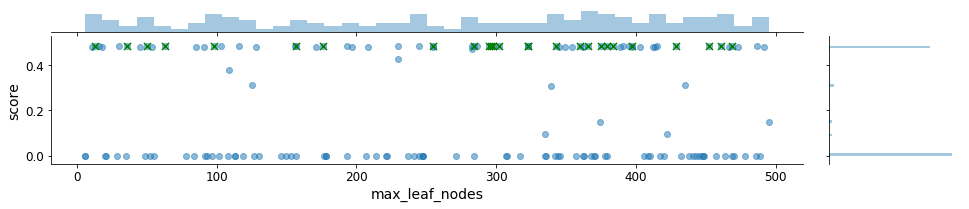

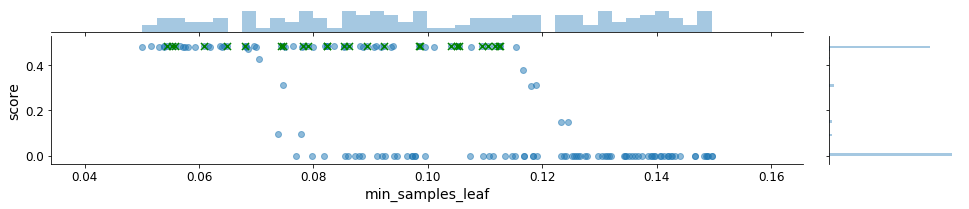

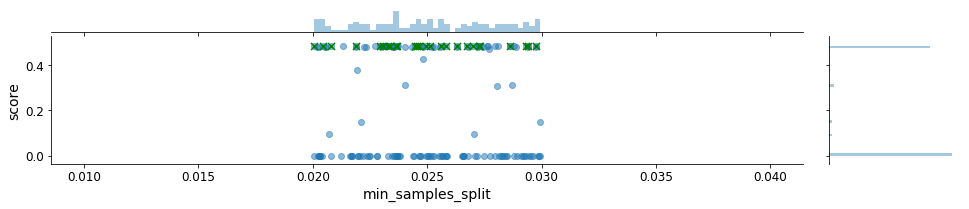

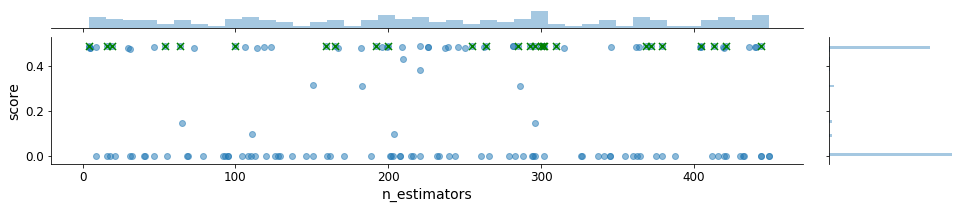

In [33]:
param_grid = {
    "criterion": ["entropy", "gini"],
    "n_estimators": stats.randint(2,450),
    "max_leaf_nodes": stats.randint(2,500),
    "max_depth": stats.randint(2,200),
    "min_samples_split": stats.uniform(0.02, 0.01),
    "min_samples_leaf": stats.uniform(0.05, 0.1),
    "bootstrap": [True, False],
    "max_features": stats.randint(2, X_val_predictions.shape[1] + 1)
    }

stacked_random_forest_grid = tune_all_parameter(param_grid, 
                                        RandomForestClassifier, 
                                        X_train = X_val_predictions,
                                        y_train = y_stack,
                                        n_iter=150, 
                                        n_jobs=5, 
                                        verbose=False);
plot_random_cv_results(stacked_random_forest_grid.cv_results_)

In [111]:
best_sgd_model, best_rf_model, best_grad_model, best_ada_model, best_extra_model, best_log_model
fi_df = pd.DataFrame([stacked_random_forest_grid.best_estimator_.feature_importances_, ["SGD", "RandomForest", "GradientBoosted", "AdaBoosted", "ExtraTrees", "LogisticalRegresssion"]]).T
fi_df.columns = ['Importance Score', 'Model']
fi_df

,Importance Score,Model
0,0.00475343,SGD
1,0,RandomForest
2,0.995247,GradientBoosted
3,0,AdaBoosted
4,0,ExtraTrees
5,0,LogisticalRegresssion


In [35]:
X_stack_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_stack_predictions[:, index] = estimator.predict(X_test)

display_score(stacked_random_forest_grid.best_estimator_, X_test=X_stack_predictions, y_test=y_test);

The f1-score for the model is 0.48551191242755953


#### Conclusions?

Explain your results and choices

(See above for choice decision)

Overall the stacked classifer was able to achieve a score of **0.48551191242755953** which was the same score as GradientBoostedClassifier (the best overall model).

We can also see from the feature importances that GradientBoosted was considered by far the most important feature while SGD (SGDClassifier) was the only other model even considered.

We could try with other classification models like **KNeighborsClassifier** or **SVC** which may have behaved more differently than the ensemble models and the stacked model may have improved.

Q. (Optional) If a Decision Tree is overfitting the training set, is it a good idea to try decreasing max_depth?

**Answer:**

Yes, if you decrase max_depth the model won't be able to create as many trees or have any many decision splits. If the splits near the bottom of the decision tree are made to account for outliers that don't generalize well pruning them will help the model not overfit.

Q. (Optional) If a Decision Tree is underfitting the training set, is it a good idea to try scaling the input features?

**Answer:**

No decision trees normally do not need to have their input features scaled due to the nature of the algorithm.

Because each split in the tree is just a condition based on a single feature the relative ranges of the features doesn't matter because they are evaluated independently. The same number of splits could be made for 100 different values between 0 and 1 and 100 different values between 0 and 10000.



Q. (Optional) What is the difference between hard and soft voting classifiers?

**Answer:**

For *hard* classifiers all the individual models pick the class they think is most likely and the final classifier goes with majority rules. (If 3 classifiers say class A and 2 say class B the final result is A).

For *soft* classifiers all the models provide their probabilities and the final class ends up being the class with the highest average probability based on all the models.

Q. (Optional) If your AdaBoost ensemble underfits the training data, what hyperparameters should you tweak and how?

**Answer**

If your AdaBoost ensemble was underfitting the training data you could try *increasing* the learning rate and *increasing* the number of estimators. 

If he training rate is too low not many estimators will be required before convergance but with no estimators the later estimators will be more trained to the earliest estimators errors compared to having fewer estimators.

Q. (Optional) If your Gradient Boosting ensemble overfits the training set, should you increase or decrease the learning rate?

**Answer**

If you gradient boosted ensemble is overfitting the data you should *decrease* the learning rate which should help due to [Shrinkage](http://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting-shrinkage)

### Conclusions


With the DecisionTreeClassifier we were able to see how dramatic of an improvement tuning the hyperparameters can have on a models performance.

In the second part we were able train a series of ensemble models (and LogisticRegression) again tuning the hyper parameters. While all the models perform similarly the GradientBoostingClassifier performed the best using F1 score as the metric.

Finally we were able to create a stacked model but it ultimately just had the same performance as our best ensemble classifier.

### Submit your notebook

Submit your solution here
https://goo.gl/forms/VKD7Zwu54oHjutDc2
Make sure you rename your notebook to    
W3_UTORid.ipynb    
Example W3_adfasd01.ipynb
